# Enoncé
## Contexte
**Mon rôle** : data scientist prestataire pour Olist

**Commanditaire** : Olist (https://olist.com/pt-br/)

**Activité de l'entreprise :** entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne

**Projet :** segmentation des clients pour leurs campagnes de communication

**Type de Mission :** classification non supervisés

## Attendus
**But de la mission :** comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles

**Détails de la mission :** fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

données anonymisée ==> https://www.kaggle.com/olistbr/brazilian-ecommerce (comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017)

comprendre les différents types d'utilisateurs --> utiliser des méthodes non supervisées pour regrouper des clients de profils similaires --> utilisées par l’équipe Marketing pour mieux communiquer

**Problèmes :** Olist n'a pas fourni beaucoup de données --> ressources limitées --> dû fournir l’ensemble des données, alors que seuls 3 % des clients ont réalisé plusieurs commandes --> les données à disposition suffiront pour réaliser un premier clustering

**Etapes demandées :**
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
- Réaliser une courte analyse exploratoire.
- Tester différents modèles de classification/segmentation afin de différencier les bons et moins bons clients en termes de commandes et de satisfaction sur l’ensemble des clients
- Faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance

/!\ Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist. /!\

**Script concerné :** 
- Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).
- Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
- **Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.**

# Librairies, paramétrages et données
## Mise à jour des librairies

In [2]:
'''
import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'])
!pip list --outdated
!pip install autopep8
'''

"\nimport re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'])\n!pip list --outdated\n!pip install autopep8\n"

## Importations des librairies

In [4]:
# Gestion de format du code
import autopep8

# Gestion des données
import pandas as pd
import numpy as np

# Gestion des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler 
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

import os
import re

## Paramétrages

In [5]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", None) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.4f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

## Importations des données

In [6]:
df = pd.read_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-5/olist_maintenance.csv'
                 , sep=","
                 , decimal = '.'
                 , encoding="utf-8")

In [7]:
df.head()

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score
0,E481F51CBDC54678B7CC49136F2D6AF7,7C396FD4830FD04220F754E42B4E5BFF,2017-10-02 10:56:33,38.7100,4
1,53CDB2FC8BC7DCE0B6741E2150273451,AF07308B275D755C9EDB36A90C618231,2018-07-24 20:41:37,141.4600,4
2,47770EB9100C2D0C44946D9CF07EC65D,3A653A41F6F9FC3D2A113CF8398680E8,2018-08-08 08:38:49,179.1200,5
3,949D5B44DBF5DE918FE9C16F97B45F8A,7C142CF63193A1473D2E66489A9AE977,2017-11-18 19:28:06,72.2000,5
4,AD21C59C0840E6CB83A9CEB5573F8159,72632F0F9DD73DFEE390C9B22EB56DD6,2018-02-13 21:18:39,28.6200,5


In [8]:
df.dtypes

order_id                     object
customer_unique_id           object
order_purchase_timestamp     object
payment_value               float64
review_score                  int64
dtype: object

In [9]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df.dtypes

order_id                            object
customer_unique_id                  object
order_purchase_timestamp    datetime64[ns]
payment_value                      float64
review_score                         int64
dtype: object

# Création des fonctions

In [11]:
def create_var(df, choice):
    # transformer le df en fonction des variables souhaitées
    if 'RFM' in choice:
        df_RFM = df.groupby(['customer_unique_id'], as_index = False)
        df_RFM = df_RFM.agg(Récence = ('order_purchase_timestamp', max)
                            , Fréquence = ('order_id', 'count')
                            , Montant = ('payment_value', 'mean'))
        df_RFM['Récence'] = (df_RFM['Récence'].max() - df_RFM['Récence']).dt.days
    if 'review' in choice:
        df_review = df_temp.groupby('customer_unique_id', as_index = False)['review_score'].mean()
    
    # créer le df final
    if len(choice) == 2:
        df_final = pd.merge(df_RFM
                            , df_review
                            , on = 'customer_unique_id'
                            , how = 'inner')
    elif len(choice) == 1:
        if 'review' in choice:
            df_final = df_review.copy()
        elif 'RFM' in choice:
            df_final = df_RFM.copy()
    
    return df_final

In [12]:
def find_update_date(algo, n_clusters, prep, nb_days_test, df, choice):
    # Df de test
    date_min_base = df['order_purchase_timestamp'].min()
    date_max_base = date_min_base + timedelta(days = 365)
    df_base = df[df['order_purchase_timestamp'] < date_max_base].copy()
    df_base = create_var(df_base, choice)
    #print('Base : de',date_min_base,'à',date_max_base)
    
    # lancement du modèle
    preprocessor = globals()[prep]()
    dict_param = {'n_clusters':n_clusters,'random_state':99,'init':'k-means++'}
    algorithm = globals()[algo](**dict_param)
    model = make_pipeline(preprocessor, algorithm)
    model.fit_predict(df_base.iloc[:,1:])
    # ajout des clusters au df
    df_base['labels'] = model.steps[-1][1].labels_
    df_base['labels'] = df_base['labels'].astype(str)
    
    score_ari = []
    periode = []
    
    # Df itératif
    date_max_test = date_max_base
    find = False
    nb_periode = 1
    i = 1
    while date_max_test < df['order_purchase_timestamp'].max():
        date_min_test = date_min_base
        date_max_test = date_max_test + timedelta(days = nb_days_test)
        df_test = df[(df['order_purchase_timestamp'] >= date_min_test)
                     &(df['order_purchase_timestamp'] < date_max_test)].copy()
        df_test = create_var(df_test, choice)
        #print('Test : de',date_min_test,'à',date_max_test)
    
        # lancement du modèle
        algorithm = globals()[algo](**dict_param)
        model = make_pipeline(preprocessor, algorithm)
        model.fit_predict(df_test.iloc[:,1:])
        # ajout des clusters au df
        df_test['labels'] = model.steps[-1][1].labels_
        df_test['labels'] = df_test['labels'].astype(str)
        
        # test de similarité
        #print(len(df_base['customer_unique_id'].to_list()))
        #print(len(df_test['customer_unique_id'].to_list()))
        df_temp_test = df_test[df_test['customer_unique_id'].isin(df_base['customer_unique_id'].to_list())]
        df_temp_base = df_base[df_base['customer_unique_id'].isin(df_test['customer_unique_id'].to_list())]
        ari = adjusted_rand_score(df_temp_base['labels'], df_temp_test['labels'])
        
        # action
        score_ari.append(ari)
        periode.append(i*nb_days_test)
        i += 1
        if find == False:
            if ari >= 0.8:
                nb_periode += 1
            else:
                find = True
    
    plt.figure(figsize = [20,10])
    plt.plot(periode, score_ari, 'bx-') 
    plt.axhline(y = 0.8, color = 'r', linestyle = '-.')
    plt.xlabel('Nombre de jours') 
    plt.xticks(periode)
    plt.ylabel('Score ARI') 
    plt.show();
    
    return nb_periode

# Contrat de maintenance

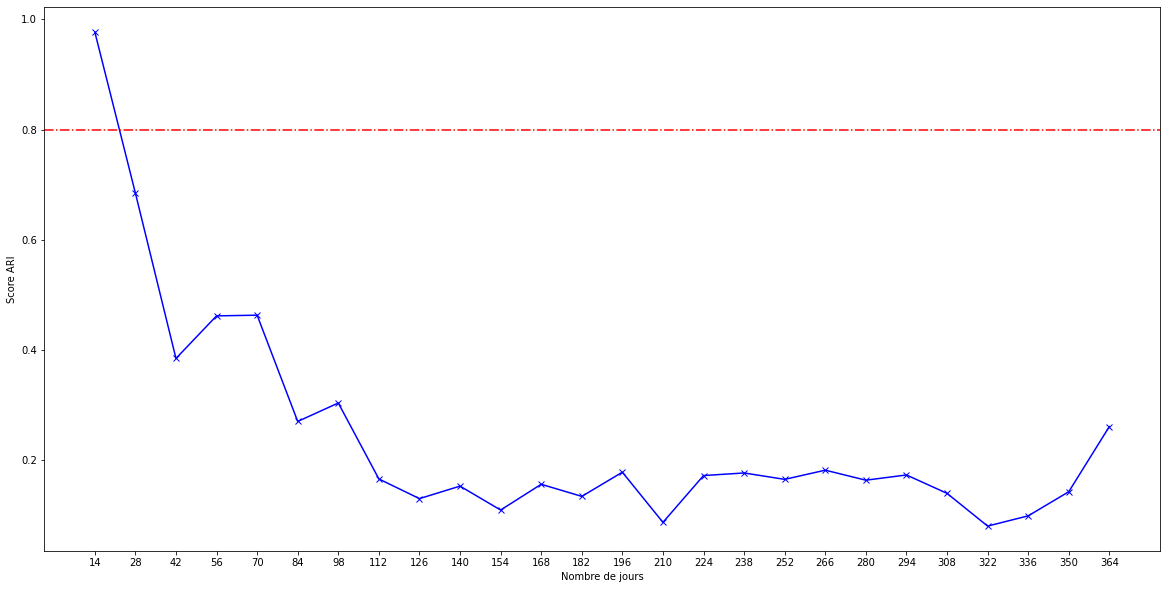

Mise à jour tous les 28 jours


In [19]:
algo = 'MiniBatchKMeans'
n_clusters = 4
prep = 'StandardScaler'
nb_days_test = 14
choice = ['RFM']
print('Mise à jour tous les',find_update_date(algo, n_clusters, prep, nb_days_test, df, choice)*nb_days_test,'jours')

# Evaluation
## Compétences évaluées et Commentaires

- Transformer les variables pertinentes d'un modèle d'apprentissage non supervisé (*Validé*)

Commentaires :

    - Les variables pertinentes ont été transformées pour permettre leur exploitation.
    - Une ou plusieurs variables pertinentes permettant d'améliorer la solution proposée ont été créées.

- Mettre en place le modèle d'apprentissage non supervisé adapté au problème métier (*Validé*)

Commentaires : Le nombre de segments et la répartition sont adaptés à la problématique métier.

- Adapter les hyperparamètres d'un algorithme non supervisé afin de l'améliorer (*Validé*)

Commentaires :

    - Les étapes d'évaluation sont automatisées pour tester facilement plusieurs combinaisons de paramètres.
    - Les valeurs de paramètres testés sont pertinemment choisies.

- Évaluer les performances d’un modèle d'apprentissage non supervisé (*Validé*)

Commentaires :

    - La forme des clusters est évaluée.
    - La stabilité des clusters est évaluée.

## Livrable et Soutenance
### Livrable

Points forts :
- Conclusion orientée métier
- Bonne contextualisation des objectifs du projet

Axes d'amélioration :
- L'étudiante aurait pu tester d'autres modèles

### Soutenance

Remarques :
- Attention à bien respecter le temps imparti 
- Présentation claire et bonne compréhension des enjeux du projet